<font face="Times New Roman" size=5>
<div dir=rtl align="center">

<font color="#800080" size=5>
Introduction to Diffusion Models  
</font>


Diffusion models have emerged as a powerful class of generative models, apable of producing high-quality and diverse outputs across various domains, including image generation, speech synthesis, and more. These models operate by simulating a process where data is gradually corrupted with noise and then reconstructed in reverse, allowing for robust generative capabilities.  

To gain a deeper understanding, **it is strongly recommended that you read [this comprehensive blog post on diffusion models by Lilian Weng](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/).** It offers an excellent overview of the topic from the very basics and theoretical foundations to practical insights, and will greatly enhance your understanding of the material covered here.  




# Part 1: Understanding the Denoising Diffusion Framework  
In this section, we’ll explore the **denoising diffusion framework** by applying the diffusion process to an example image.  

- **Forward Process**: We’ll progressively add noise to the image, simulating how data is corrupted over a series of steps.  
- **Reverse Process**: We’ll then demonstrate how the model learns to reverse this process, removing noise step-by-step to reconstruct the original image.  



In [2]:
import sys
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import imageio

In [3]:
! git clone https://github.com/mikonvergence/DiffusionFastForward
!pip install pytorch-lightning==1.9.3 diffusers einops kornia

import sys
sys.path.append('./DiffusionFastForward/')

fatal: destination path 'DiffusionFastForward' already exists and is not an empty directory.


### Choose your sample image
To get started, you’ll need to select an image to use for this section. This image will serve as the input for the diffusion process. Feel free to choose any image you like. The majority of the diffusion models assume that the images are scaled to the `[-1, +1]` range (which tends to simplify many equations). This tutorial will follow the same approach, so we need to define input and output transformation functions `input_T()` and `output_T()`. Also, let's define our own `show()` wrapper function that displays the image with automatic output transformation!

In [ ]:
img = torch.FloatTensor(imageio.imread('/kaggle/input/picture/sample.png')/255)
plt.imshow(img)

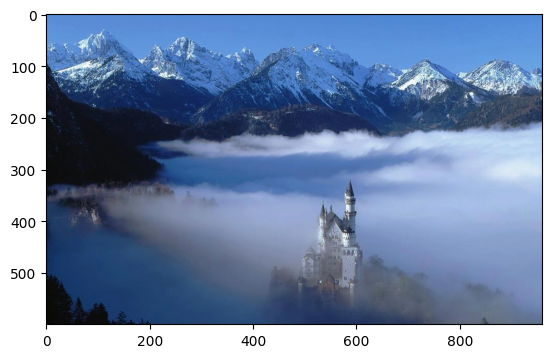

In [5]:
def input_T(input):
    # [0, 1] -> [-1, +1]
    return 2*input-1

def output_T(input):
    # [-1, +1] -> [0, 1]
    return (input+1)/2

def show(input):
    plt.imshow(output_T(input).clip(0, 1))

img_ = input_T(img)
show(img_)

### Defining a schedule
The diffusion process is built based on a variance schedule, which determines the levels of added noise at each step of the process. To that end, our schedule is defined below, with the following quantities:

* `betas`: $\beta_t$


* `alphas`: $\alpha_t = 1-\beta_t$


* `alphas_sqrt`:  $\sqrt{\alpha_t}$


* `alphas_prod`: $\bar{\alpha}_t = \prod_{i = 0}^{t}\alpha_i$

In [6]:
num_timesteps = 1000
betas = torch.linspace(1e-4, 2e-2, num_timesteps)

alphas = 1-betas
alphas_sqrt = alphas.sqrt()
alphas_cumprod = torch.cumprod(alphas, 0)
alphas_cumprod_sqrt = alphas_cumprod.sqrt()

## Forward Process
The forward process $q$ determines how subsequent steps in the diffusion are derived (gradual distortion of the original sample $x_0$).

First, let's bring up the key equations describing this process...

Basic format of the forward step:
$$q(x_t|x_{t−1}) : =  \mathcal{N}(x_t; \sqrt{1 − \beta_t}x_{t−1}, \beta_tI) \tag{1}$$

to step directly from $x_0$ to $x_t$:
$$q(x_t|x_0) = \mathcal{N}(x_t;\sqrt{\bar{\alpha_t}}x_0, (1 − \bar{\alpha_t})I) \tag{2}$$

Now let's define a function `forward_step()` that will allow us to use both $q(x_t|x_{t-1})$ and  `forward_jump()` for $q(x_t|x_0)$.

In [7]:
def forward_step(t, condition_img, return_noise = False):
    """
        forward step: t-1 -> t
    """
    assert t >= 0

    mean = alphas_sqrt[t] * condition_img
    std = torch.sqrt(betas[t])

    # sampling from N
    if not return_noise:
        output = mean + std * torch.randn_like(img)
        return output
    else:
        noise = torch.normal(mean, std, condition_img)
        output = condition_img + noise
        return output, noise

def forward_jump(t, condition_img, condition_idx = 0, return_noise = False):
    """
        forward jump: 0 -> t
    """
    assert t >= 0

    mean = alphas_cumprod_sqrt[t] * condition_img
    std = (1 - alphas_cumprod[t]).sqrt()

    # sampling from N
    if not return_noise:
        output = mean + std * torch.randn_like(img)
        return output
    else:
        noise = torch.randn_like(img)
        output = mean + std * noise
        return output, noise

In [8]:
N = 5 # number of computed states between x_0 and x_T
M = 4 # number of samples taken from each distribution

In the first example, when `t = 0`, we want to derive a sample $x_t$ based on the clean sample $x_0$!

The first column shows the mean image for a given stage of the diffusion, and the subsequent columns to the right show several samples taken from the same distribution (they are different if you look closely!).

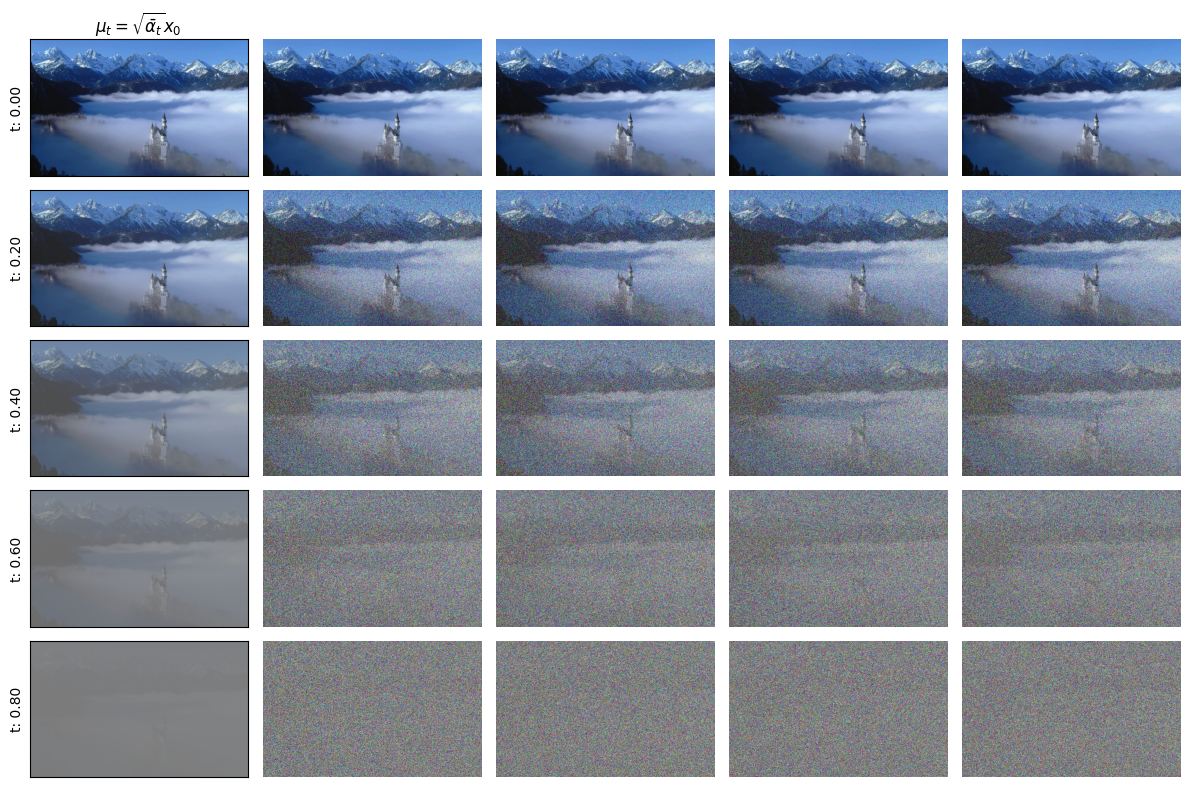

In [9]:
plt.figure(figsize = (12, 8))
for idx in range(N):
    t_step = int(idx*(num_timesteps/N))

    plt.subplot(N, 1+M, 1+(M+1)*idx)
    show(alphas_cumprod_sqrt[t_step]*img_)
    plt.title(r'$\mu_t = \sqrt{\bar{\alpha}_t}x_0$') if idx == 0 else None
    plt.ylabel("t: {:.2f}".format(t_step/num_timesteps))
    plt.xticks([])
    plt.yticks([])

    for sample in range(M):
        x_t = forward_jump(t_step, img_)

        plt.subplot(N, 1+M, 2+(1+M)*idx+sample)
        show(x_t)
        plt.axis('off')

plt.tight_layout()

Alternatively, we can test the process of going from $x_{t-1}$ to $x_t$, which is a single step in the diffusion process. For that we can use the `forward_step` function.

Note that the mean $\mu_t$ is now a bit different (first column) since it is conditioned on a specific sample of $x_{t-1}$!

In [ ]:
plt.figure(figsize = (12, 8))
for idx in range(N):
    t_step = int(idx*(num_timesteps/N))
    prev_img = forward_jump(max([0, t_step-1]), img_) # directly go to prev state

    plt.subplot(N, 1+M, 1+(M+1)*idx)
    show(alphas_sqrt[t_step]*prev_img)
    plt.title(r'$\mu_t = \sqrt{1-\beta_t}x_{t-1}$') if idx == 0 else None
    plt.ylabel("t: {:.2f}".format(t_step/num_timesteps))
    plt.xticks([])
    plt.yticks([])

    for sample in range(M):
        plt.subplot(N, 1+M, 2+(1+M)*idx+sample)
        x_t = forward_step(t_step, prev_img)
        show(x_t)
        plt.axis('off')
plt.tight_layout()

## Reverse Process

The purpose of the reverse process $p$ is to approximate the previous step $x_{t-1}$ in the diffusion chain based on a sample $x_t$. In practice, this approximation $p(x_{t-1}|x_t)$ must be done without the knowledge of $x_0$.

A parametrizable prediction model with parameters $\theta$ is used to estimate $p_\theta(x_{t-1}|x_t)$.

The reverse process will also be (approximately) gaussian if the diffusion steps are small enough:

$$p_\theta(x_{t-1}|x_t) : =  \mathcal{N}(x_{t-1};\mu_\theta(x_t), \Sigma_\theta(x_t))\tag{3}$$

In many works, it is assumed that the variance of this distribution should not depend strongly on $x_0$ or $x_t$, but rather on the stage of the diffusion process $t$. This can be observed in the true distribution $q(x_{t-1}|x_t, x_0)$, where the variance of the distribution equals $\tilde{\beta}_t$.

### Parameterizing $\mu_\theta$
There are at least 3 ways of parameterizing the mean of the reverse step distribution $p_\theta(x_{t-1}|x_t)$:
* Directly (a neural network will estimate $\mu_\theta$)
* Via $x_0$ (a neural network will estimate $x_0$)
$$\tilde{\mu}_\theta = \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1-\bar{\alpha}_t}x_0 + \frac{\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}x_t\tag{4}$$
* Via noise $\epsilon$ subtraction from $x_0$ (a neural network will estimate $\epsilon$)
$$x_0 = \frac{1}{\sqrt{\bar{\alpha}_t}}(x_t-\sqrt{1-\bar{\alpha}_t}\epsilon)\tag{5}$$

The approach of approximating the normal noise $\epsilon$ is used most widely.

Let's look at what an example $\epsilon$ might look like:

In [ ]:
t_step = 50

x_t, noise = forward_jump(t_step, img_, return_noise = True)

plt.subplot(1, 3, 1)
show(img_)
plt.title(r'$x_0$')
plt.axis('off')
plt.subplot(1, 3, 2)
show(x_t)
plt.title(r'$x_t$')
plt.axis('off')
plt.subplot(1, 3, 3)
show(noise)
plt.title(r'$\epsilon$')
plt.axis('off')

If $\epsilon$ is predicted correctly, we can use the equation (5) to predict $x_0$:

In [ ]:
x_0_pred = (x_t-(1-alphas_cumprod[t_step]).sqrt()*noise)/(alphas_cumprod_sqrt[t_step])

plt.subplot(1, 3, 1)
show(x_t)
plt.title('$x_t$ ($\ell_1$: {:.3f})'.format(F.l1_loss(x_t, img_)))
plt.axis('off')
plt.subplot(1, 3, 2)
show(x_0_pred)
plt.title('$x_0$ prediction ($\ell_1$: {:.3f})'.format(F.l1_loss(x_0_pred, img_)))
plt.axis('off')
plt.subplot(1, 3, 3)
show(img_)
plt.title('$x_0$')
plt.axis('off')

Approximation (or knowledge) of $x_0$ allows us to approximate the mean of the step $t-1$, using (4).

In [ ]:
# estimate mean
mean_pred = x_0_pred*(alphas_cumprod_sqrt[t_step-1]*betas[t_step])/(1-alphas_cumprod[t_step]) + x_t*(alphas_sqrt[t_step]*(1-alphas_cumprod[t_step-1]))/(1-alphas_cumprod[t_step])

# let's compare it to ground truth mean of the previous step (requires knowledge of x_0)
mean_gt = alphas_cumprod_sqrt[t_step-1]*img_

Since reverse process mean estimation $\tilde{\mu}_\theta$ in (4) is effectively linear interpolation between noisy $x_t$ and $x_0$ it is expected to have a higher error (as the additive noise is still present) compared to the mean computed using the forward process (which is computed by scaling the clean sample by a scalar value).

In [ ]:
plt.subplot(1, 3, 1)
show(x_t)
plt.title('$x_t$   ($\ell_1$: {:.3f})'.format(F.l1_loss(x_t, img_)))
plt.subplot(1, 3, 2)
show(mean_pred)
plt.title(r'$\tilde{\mu}_{t-1}$' + '  ($\ell_1$: {:.3f})'.format(F.l1_loss(mean_pred, img_)))
plt.subplot(1, 3, 3)
show(mean_gt)
plt.title(r'$\mu_{t-1}$' + '  ($\ell_1$: {:.3f})'.format(F.l1_loss(mean_gt, img_)))

Once we get our `mean_pred` ($\tilde{\mu_{t}}$), we can define our distribution for the previous step

$$\tilde{\beta}_t = \beta_t \tag{6}$$

$$ p_\theta(x_{t-1}|x_t) : =  \mathcal{N}(x_{t-1};\tilde{\mu}_\theta(x_t, t), \tilde{\beta}_t I) \tag{7}$$

> Important: the experiment below should be treated as a simulation. In practice, the network must  predict either $\epsilon$ or $x_0$ or $\tilde{\mu}_\theta$. Here, the value of $epsilon$ is simply subs

In [ ]:
def reverse_step(epsilon, x_t, t_step, return_noise = False):

    # estimate x_0 based on epsilon
    x_0_pred = (x_t - (1 - alphas_cumprod[t_step]).sqrt()*epsilon) / (alphas_cumprod_sqrt[t_step])
    if t_step == 0:
        sample = x_0_pred
        noise = torch.zeros_like(x_0_pred)
    else:
        # estimate mean
        mean_pred = x_0_pred * (alphas_cumprod_sqrt[t_step-1] * betas[t_step]) / (1 - alphas_cumprod[t_step]) + x_t * (alphas_sqrt[t_step] * (1 - alphas_cumprod[t_step-1])) / (1 - alphas_cumprod[t_step])


        # compute variance
        beta_pred = betas[t_step].sqrt() if t_step != 0 else 0

        sample = mean_pred+beta_pred*torch.randn_like(x_t)
        # this noise is only computed for simulation purposes (since x_0_pred is not known normally)
        noise = (sample - x_0_pred * alphas_cumprod_sqrt[t_step-1]) / (1 - alphas_cumprod[t_step-1]).sqrt()
    if return_noise:
        return sample, noise
    else:
        return sample

In [ ]:
x_t, noise = forward_jump(1000-1, img_, return_noise = True)

state_imgs = [x_t.numpy()]
for t_step in reversed(range(1000)):
    x_t, noise = reverse_step(noise, x_t, t_step, return_noise = True)

    if t_step % 200 ==  0:
        state_imgs.append(x_t.numpy())

In [ ]:
plt.figure()
for idx, state_img in enumerate(state_imgs):
    plt.subplot(1, len(state_imgs), idx+1)
    show(state_img.clip(-1, 1))
    plt.axis('off')

plt.tight_layout()

## Packaging into Components
The processes investigated above are neatly packaged into modular components for easier management of the diffusion framework.

First, the forward process component `GaussianForwardProcess` encapsulates the functions of $q(x_t|x_0)$ and $q(x_t|x_{t-1})$.

Below, we can see how different schedules of the variance parameter $\beta$ affect how the noise level changes throughout the progression.

In [ ]:
from src import *

D = 128
make_white = False
save = False
line_color = 'black' #'#9EFFB9'
test_img = img[256-D:256+D, 512-D:512+D, :]

for schedule in ['linear', 'quadratic', 'sigmoid', 'cosine']:
    fw = GaussianForwardProcess(1000,
                              schedule)

    plt.figure(figsize = (10, 2))
    plt.subplot(1, 6, 1)
    plt.plot(fw.betas, color = line_color)
    plt.title(schedule, color = line_color)
    plt.xlabel(r'step $t$', color = line_color)
    plt.ylabel(r'$\beta_t$', color = line_color)

    if make_white:
        plt.xticks(color = 'white')
        plt.gca().tick_params(axis = 'x', colors = 'white')
        plt.gca().tick_params(axis = 'y', colors = 'white')
        plt.gca().spines['top'].set_color('white')
        plt.gca().spines['right'].set_color('white')
        plt.gca().spines['left'].set_color('white')
        plt.gca().spines['bottom'].set_color('white')
    for step in range(5):
        plt.subplot(1, 6, step+2)
        plt.imshow(fw(test_img.permute(2, 0, 1).unsqueeze(0), torch.tensor(step*200))[0].permute(1, 2, 0))
        plt.axis('off')
    plt.tight_layout()


    if save:
        plt.savefig('{}.png'.format(schedule),
                    dpi = 200,
                    bbox_inches = 'tight',
                    pad_inches = 0.0,
                    transparent = True)

# Part 2: DDPM from Scratch in PyTorch

In this notebook, we will dive into implementing the foundational concepts from the seminal paper **[Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239)** by Jonathan Ho et al., which introduced the modern formulation of diffusion models.  

#### Key Objectives:  
1. **Implementation**: We will develop the diffusion model framework step by step in PyTorch.  
2. **Training**: Train the implemented model on the **MNIST dataset**, a classic benchmark for image generation tasks.  
3. **Image Generation**: Use the trained model to generate new, high-quality images from noise.  
4. **Performance Evaluation**: Evaluate the quality of the generated images using quantitative and qualitative measures.  

This notebook is designed as a hands-on, interactive implementation of diffusion models to deepen your understanding of both the theoretical and practical aspects.  

## Forward Process
### A quick review
 The Forward Process gradually transforms the image into a Normal Distribution by introducing noise over T time steps.
 The author adds the noise gradually according to the below Gaussian Distribution. Note that the noise is controlled by the parameter β<sub>t</sub>.

$$ q(x_{t} | x_{t-1}) := \mathcal{N} \left( x_{t}; \sqrt{(1 - \beta_{t})}x_{t-1}, \beta_{t} I \right) \text{ where } \beta_{t} \lt 1 \text{ for all } t $$

* For forward process, Author opts for the below configuration:

    1. Time steps (T) = 1000
    2. *β<sub>1</sub> = 10<sup>-4</sup> and β<sub>T</sub> = 0.02*
    3. β is linearly scheduled which means *β<sub>t</sub> = β<sub>1</sub> + (β<sub>T</sub> x (t-1))/T*
    

$$ q(x_t | x_0) = \mathcal{N} \left( x_t; \sqrt{\bar{\alpha_t}} x_0, (1 - \bar{\alpha_t})I \right) $$
where $$ \alpha_t := 1 - \beta_t $$
$$ \bar{\alpha}_t :=  \prod_{s=1}^{t} \alpha_s $$

Using Reparameterization Trick; *x<sub>t</sub>* for all time steps can be computed using below formula.

$$ x_t = \sqrt{\bar{\alpha_t}} x_0 + \sqrt{(1 - \bar{\alpha_t})}\epsilon $$


Note that there are **no trainable parameter** involved in the forward process.
Let's implement everything we discussed in the forward process.


In [2]:
!pip install scipy==1.11.1

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class DiffusionForwardProcess:

    r"""

    Forward Process class as described in the
    paper "Denoising Diffusion Probabilistic Models"

    """

    def __init__(self,
                 num_time_steps = 1000,
                 beta_start = 1e-4,
                 beta_end = 0.02
                ):

        # Precomputing beta, alpha, and alpha_bar for all t's.
        self.betas = torch.linspace(beta_start, beta_end, num_time_steps)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bars = torch.sqrt(self.alpha_bars)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1 - self.alpha_bars)

    def add_noise(self, original, noise, t):

        r""" Adds noise to a batch of original images at time-step t.

        :param original: Input Image Tensor
        :param noise: Random Noise Tensor sampled from Normal Dist N(0, 1)
        :param t: timestep of the forward process of shape -> (B, )

        """

        sqrt_alpha_bar_t = self.sqrt_alpha_bars.to(original.device)[t]
        sqrt_one_minus_alpha_bar_t = self.sqrt_one_minus_alpha_bars.to(original.device)[t]

        sqrt_alpha_bar_t = sqrt_alpha_bar_t[:, None, None, None]
        sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar_t[:, None, None, None]

        return (sqrt_alpha_bar_t * original) + (sqrt_one_minus_alpha_bar_t * noise)


In [ ]:
# Test
original = torch.randn(4, 1, 28, 28)
noise = torch.randn(4, 1, 28, 28)
t_steps = torch.randint(0, 1000, (4,))

# Forward Process
dfp = DiffusionForwardProcess()
out = dfp.add_noise(original, noise, t_steps)
out.shape

## Reverse Process

 Reverse process can be think of as a **Inverse of the Forward Process**.
 The Goal of the reverse process is to gradually denoise the noisy image *x<sub>T</sub> ~ N(0, 1)* in T time steps.

 In Reverse Process; the image *x<sub>t-1</sub>* is obtained from *x<sub>t</sub>* using below formulation. Note that the **noise *e<sub>theta</sub>* is predicted by the model (U-net)** which we will implement in the next section.

$$  x_{t-1} = \frac{1}{\sqrt\alpha_t} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \, \epsilon_\theta \right) + \sigma_t z $$

where

$$ z \sim \mathcal{N}(0, I) $$

 Also at each time-step, original image *x<sub>0</sub>* can be predicted using below formula.

$$  x_{0} = \frac{1}{\sqrt{\bar{\alpha}_t}} \left( x_t - {\sqrt{1 - \bar{\alpha}_t}} \, \epsilon_\theta \right) $$

Let's implement the reverse process as described.

In [ ]:
class DiffusionReverseProcess:

    r"""

    Reverse Process class as described in the
    paper "Denoising Diffusion Probabilistic Models"

    """

    def __init__(self,
                 num_time_steps = 1000,
                 beta_start = 1e-4,
                 beta_end = 0.02
                ):

        # Precomputing beta, alpha, and alpha_bar for all t's.
        self.b = torch.linspace(beta_start, beta_end, num_time_steps) # b -> beta
        self.a = 1 - self.b # a -> alpha
        self.a_bar = torch.cumprod(self.a, dim=0) # a_bar = alpha_bar

    def sample_prev_timestep(self, xt, noise_pred, t):

        """ Sample x_(t-1) given x_t and noise predicted
             by model.

             :param xt: Image tensor at timestep t of shape -> B x C x H x W
             :param noise_pred: Noise Predicted by model of shape -> B x C x H x W
             :param t: Current time step

        """

        # Original Image Prediction at timestep t
        x0 = xt - (torch.sqrt(1 - self.a_bar.to(xt.device)[t]) * noise_pred)
        x0 = x0/torch.sqrt(self.a_bar.to(xt.device)[t])
        x0 = torch.clamp(x0, -1, 1)

        # mean of x_(t-1)
        mean = xt - ((1 - self.a.to(xt.device)[t]) * noise_pred)/(torch.sqrt(1 - self.a_bar.to(xt.device)[t]))
        mean = mean/ torch.sqrt(self.a.to(xt.device)[t])

        # only return mean
        if t == 0:
            return mean, x0

        else:
            variance = (1 - self.a_bar.to(xt.device)[t-1]) / (1 - self.a_bar.to(xt.device)[t])
            variance = variance * self.b.to(xt.device)[t]
            sigma = variance**0.5
            z = torch.randn(xt.shape).to(xt.device)

            return mean + sigma * z, x0

In [ ]:
# Test
original = torch.randn(1, 1, 28, 28)
noise_pred = torch.randn(1, 1, 28, 28)
t = torch.randint(0, 1000, (1,))

# Forward Process
drp = DiffusionReverseProcess()
out, x0 = drp.sample_prev_timestep(original, noise_pred, t)
out.shape

## Model Architecture

 In the paper, author uses **U-net** architecture to predict the noise.
 U-net takes noisy image at time-step T and time-step T as input and returns the predicted noise which will be used to predict *x<sub>t-1</sub>* and *x<sub>0</sub>*.

Let's implement modules required for U-net.

### Time Embedding

 In Diffusion model, Time information is important. The model needs to be aware of the specific time step at which it is predicting noise.

 The idea to embed the time information is taken from the positional time embedding used in the Transformers. The time embedding is done using below formula. **d_embed** is the embedding dimension.

$$ PE(pos, 0:d_{\text{embed}}/2) = \sin\left(\frac{pos}{10000^{2i/d_{\text{embed}}}}\right) $$

$$ PE(pos, d_{\text{embed}}/2:d_{\text{embed}}) = \cos\left(\frac{pos}{10000^{2i/d_{\text{embed}}}}\right) $$

Let's implement the Time Embedding Layer.


In [ ]:
def get_time_embedding(
    time_steps: torch.Tensor,
    t_emb_dim: int
) -> torch.Tensor:

    """
    Transform a scalar time-step into a vector representation of size t_emb_dim.

    :param time_steps: 1D tensor of size -> (Batch,)
    :param t_emb_dim: Embedding Dimension -> for ex: 128 (scalar value)

    :return tensor of size -> (B, t_emb_dim)
    """

    assert t_emb_dim%2 == 0, "time embedding must be divisible by 2."

    factor = 2 * torch.arange(start = 0,
                              end = t_emb_dim//2,
                              dtype=torch.float32,
                              device=time_steps.device
                             ) / (t_emb_dim)

    factor = 10000**factor

    t_emb = time_steps[:,None] # B -> (B, 1)
    t_emb = t_emb/factor # (B, 1) -> (B, t_emb_dim//2)
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=1) # (B , t_emb_dim)

    return t_emb

### U-net

 The purpose of this section is for you to dive more deeply into the U-net architecture, so just read on. Diffusion Model predicts the amount of noise given noisy image at different time-steps.
 Note that Input and Output both are **2-Dimensional images**, Hence U-net type architecture is suitable for this task.

 The U-net architecture begins by taking an image as input. It then proceeds to extract features while downsampling, followed by refining these downsampled features. Finally, it upsamples the refined features to reconstruct an image of the same size as the output.

 U-net architecture consists of 3 main blocks.

1. Down-Convolutional Block
2. Mid-Conv Block
3. Up-Conv block
    
    
    
 A typical U-net block looks something like this.

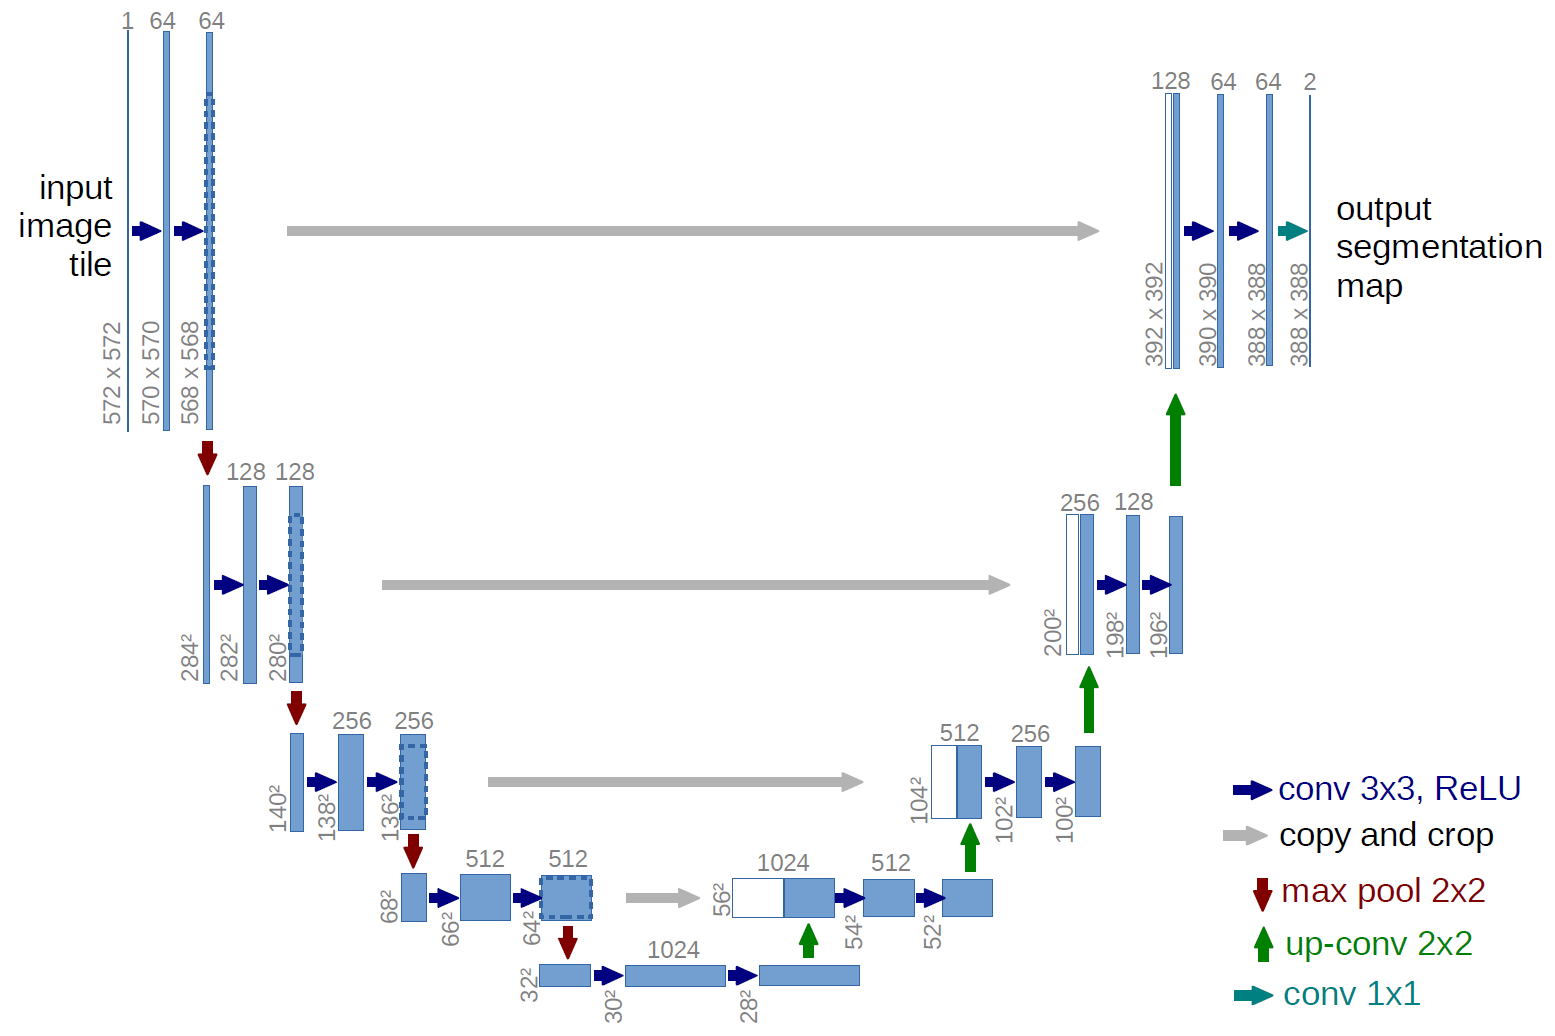![](attachment:959c755b-8b93-4979-ac60-345281bf054c.png)

In [ ]:
class NormActConv(nn.Module):
    """
    Perform GroupNorm, Activation, and Convolution operations.
    """
    def __init__(self,
                 in_channels:int,
                 out_channels:int,
                 num_groups:int = 8,
                 kernel_size: int = 3,
                 norm:bool = True,
                 act:bool = True
                ):
        super(NormActConv, self).__init__()

        # GroupNorm
        self.g_norm = nn.GroupNorm(
            num_groups,
            in_channels
        ) if norm is True else nn.Identity()

        # Activation
        self.act = nn.SiLU() if act is True else nn.Identity()

        # Convolution
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            padding=(kernel_size - 1)//2
        )

    def forward(self, x):
        x = self.g_norm(x)
        x = self.act(x)
        x = self.conv(x)
        return x

#-----------------------------------------------------------------

class TimeEmbedding(nn.Module):
    """
    Maps the Time Embedding to the Required output Dimension.
    """
    def __init__(self,
                 n_out:int, # Output Dimension
                 t_emb_dim:int = 128 # Time Embedding Dimension
                ):
        super(TimeEmbedding, self).__init__()

        # Time Embedding Block
        self.te_block = nn.Sequential(
            nn.SiLU(),
            nn.Linear(t_emb_dim, n_out)
        )

    def forward(self, x):
        return self.te_block(x)

#---------------------------------------------------------------

class SelfAttentionBlock(nn.Module):
    """
    Perform GroupNorm and Multiheaded Self Attention operation.
    """
    def __init__(self,
                 num_channels:int,
                 num_groups:int = 8,
                 num_heads:int = 4,
                 norm:bool = True
                ):
        super(SelfAttentionBlock, self).__init__()

        # GroupNorm
        self.g_norm = nn.GroupNorm(
            num_groups,
            num_channels
        ) if norm is True else nn.Identity()

        # Self-Attention
        self.attn = nn.MultiheadAttention(
            num_channels,
            num_heads,
            batch_first=True
        )

    def forward(self, x):
        batch_size, channels, h, w = x.shape
        x = x.reshape(batch_size, channels, h*w)
        x = self.g_norm(x)
        x = x.transpose(1, 2)
        x, _ = self.attn(x, x, x)
        x = x.transpose(1, 2).reshape(batch_size, channels, h, w)
        return x

#----------------------------------------------------------------

class Downsample(nn.Module):
    """
    Perform Downsampling by the factor of k across Height and Width.
    """
    def __init__(self,
                 in_channels:int,
                 out_channels:int,
                 k:int = 2, # Downsampling factor
                 use_conv:bool = True, # If Downsampling using conv-block
                 use_mpool:bool = True # If Downsampling using max-pool
                ):
        super(Downsample, self).__init__()

        self.use_conv = use_conv
        self.use_mpool = use_mpool

        # Downsampling using Convolution
        self.cv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=1),
            nn.Conv2d(
                in_channels,
                out_channels//2 if use_mpool else out_channels,
                kernel_size=4,
                stride=k,
                padding=1
            )
        ) if use_conv else nn.Identity()

        # Downsampling using Maxpool
        self.mpool = nn.Sequential(
            nn.MaxPool2d(k, k),
            nn.Conv2d(
                in_channels,
                out_channels//2 if use_conv else out_channels,
                kernel_size=1,
                stride=1,
                padding=0
            )
        ) if use_mpool else nn.Identity()

    def forward(self, x):

        if not self.use_conv:
            return self.mpool(x)

        if not self.use_mpool:
            return self.cv(x)

        return torch.cat([self.cv(x), self.mpool(x)], dim=1)

#-----------------------------------------------------------------------

class Upsample(nn.Module):
    """
    Perform Upsampling by the factor of k across Height and Width
    """
    def __init__(self,
                 in_channels:int,
                 out_channels:int,
                 k:int = 2, # Upsampling factor
                 use_conv:bool = True, # Upsampling using conv-block
                 use_upsample:bool = True # Upsampling using nn.upsample
                ):
        super(Upsample, self).__init__()

        self.use_conv = use_conv
        self.use_upsample = use_upsample

        # Upsampling using conv
        self.cv = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels//2 if use_upsample else out_channels,
                kernel_size=4,
                stride=k,
                padding=1
            ),
            nn.Conv2d(
                out_channels//2 if use_upsample else out_channels,
                out_channels//2 if use_upsample else out_channels,
                kernel_size = 1,
                stride=1,
                padding=0
            )
        ) if use_conv else nn.Identity()

        # Upsamling using nn.Upsample
        self.up = nn.Sequential(
            nn.Upsample(
                scale_factor=k,
                mode = 'bilinear',
                align_corners=False
            ),
            nn.Conv2d(
                in_channels,
                out_channels//2 if use_conv else out_channels,
                kernel_size=1,
                stride=1,
                padding=0
            )
        ) if use_upsample else nn.Identity()

    def forward(self, x):

        if not self.use_conv:
            return self.up(x)

        if not self.use_upsample:
            return self.cv(x)

        return torch.cat([self.cv(x), self.up(x)], dim=1)

In [ ]:
layer = Upsample(16, 32, 2, True, True)
x = torch.randn(4, 16, 32, 32)
layer(x).shape

**Down-Conv Block**

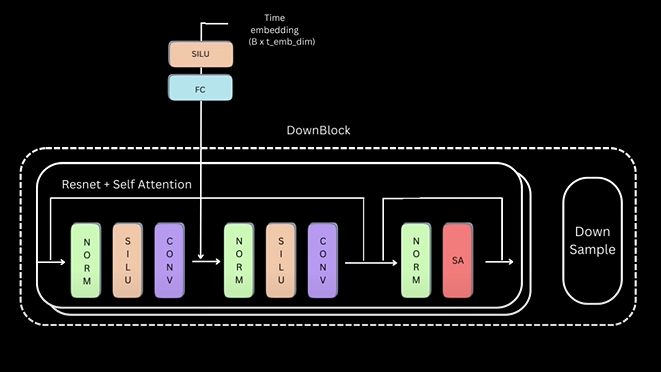

In [ ]:
class DownC(nn.Module):
    """
    Perform Down-convolution on the input using following approach.
    1. Conv + TimeEmbedding
    2. Conv
    3. Skip-connection from input x.
    4. Self-Attention
    5. Skip-Connection from 3.
    6. Downsampling
    """
    def __init__(self,
                 in_channels:int,
                 out_channels:int,
                 t_emb_dim:int = 128, # Time Embedding Dimension
                 num_layers:int=2,
                 down_sample:bool = True # True for Downsampling
                ):
        super(DownC, self).__init__()

        self.num_layers = num_layers

        self.conv1 = nn.ModuleList([
            NormActConv(in_channels if i==0 else out_channels,
                        out_channels
                       ) for i in range(num_layers)
        ])

        self.conv2 = nn.ModuleList([
            NormActConv(out_channels,
                        out_channels
                       ) for _ in range(num_layers)
        ])

        self.te_block = nn.ModuleList([
            TimeEmbedding(out_channels, t_emb_dim) for _ in range(num_layers)
        ])

        self.attn_block = nn.ModuleList([
            SelfAttentionBlock(out_channels) for _ in range(num_layers)
        ])

        self.down_block =Downsample(out_channels, out_channels) if down_sample else nn.Identity()

        self.res_block = nn.ModuleList([
            nn.Conv2d(
                in_channels if i==0 else out_channels,
                out_channels,
                kernel_size=1
            ) for i in range(num_layers)
        ])

    def forward(self, x, t_emb):

        out = x

        for i in range(self.num_layers):
            resnet_input = out

            # Resnet Block
            out = self.conv1[i](out)
            out = out + self.te_block[i](t_emb)[:, :, None, None]
            out = self.conv2[i](out)
            out = out + self.res_block[i](resnet_input)

            # Self Attention
            out_attn = self.attn_block[i](out)
            out = out + out_attn

        # Downsampling
        out = self.down_block(out)

        return out

**Mid-Conv Block**

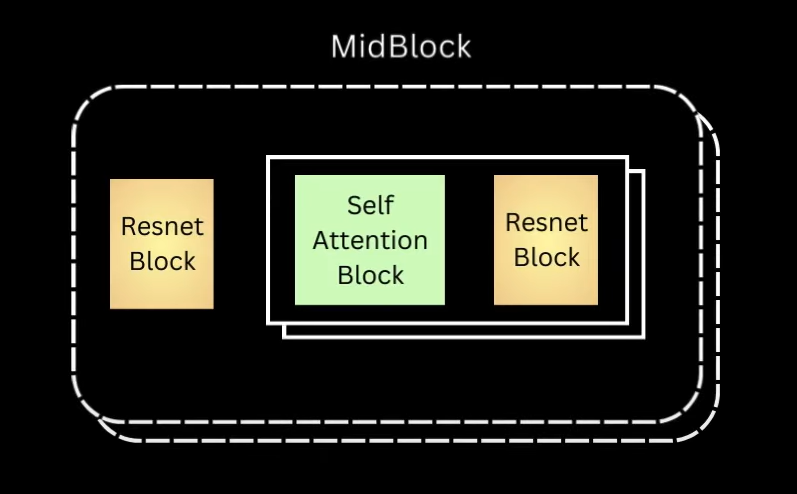

In [ ]:
class MidC(nn.Module):
    """
    Refine the features obtained from the DownC block.
    It refines the features using following operations:

    1. Resnet Block with Time Embedding
    2. A Series of Self-Attention + Resnet Block with Time-Embedding
    """
    def __init__(self,
                 in_channels:int,
                 out_channels:int,
                 t_emb_dim:int = 128,
                 num_layers:int = 2
                ):
        super(MidC, self).__init__()

        self.num_layers = num_layers

        self.conv1 = nn.ModuleList([
            NormActConv(in_channels if i==0 else out_channels,
                        out_channels
                       ) for i in range(num_layers + 1)
        ])

        self.conv2 = nn.ModuleList([
            NormActConv(out_channels,
                        out_channels
                       ) for _ in range(num_layers + 1)
        ])

        self.te_block = nn.ModuleList([
            TimeEmbedding(out_channels, t_emb_dim) for _ in range(num_layers + 1)
        ])

        self.attn_block = nn.ModuleList([
            SelfAttentionBlock(out_channels) for _ in range(num_layers)
        ])

        self.res_block = nn.ModuleList([
            nn.Conv2d(
                in_channels if i==0 else out_channels,
                out_channels,
                kernel_size=1
            ) for i in range(num_layers + 1)
        ])

    def forward(self, x, t_emb):
        out = x

        # First-Resnet Block
        resnet_input = out
        out = self.conv1[0](out)
        out = out + self.te_block[0](t_emb)[:, :, None, None]
        out = self.conv2[0](out)
        out = out + self.res_block[0](resnet_input)

        # Sequence of Self-Attention + Resnet Blocks
        for i in range(self.num_layers):

            # Self Attention
            out_attn = self.attn_block[i](out)
            out = out + out_attn

            # Resnet Block
            resnet_input = out
            out = self.conv1[i+1](out)
            out = out + self.te_block[i+1](t_emb)[:, :, None, None]
            out = self.conv2[i+1](out)
            out = out + self.res_block[i+1](resnet_input)

        return out

**Up-Conv Block**

Exactly same as DownC Block except Downsampling block is replaced by Upsampling.

In [ ]:
class UpC(nn.Module):
    """
    Perform Up-convolution on the input using following approach.
    1. Upsampling
    2. Conv + TimeEmbedding
    3. Conv
    4. Skip-connection from 1.
    5. Self-Attention
    6. Skip-Connection from 3.
    """
    def __init__(self,
                 in_channels:int,
                 out_channels:int,
                 t_emb_dim:int = 128, # Time Embedding Dimension
                 num_layers:int = 2,
                 up_sample:bool = True # True for Upsampling
                ):
        super(UpC, self).__init__()

        self.num_layers = num_layers

        self.conv1 = nn.ModuleList([
            NormActConv(in_channels if i==0 else out_channels,
                        out_channels
                       ) for i in range(num_layers)
        ])

        self.conv2 = nn.ModuleList([
            NormActConv(out_channels,
                        out_channels
                       ) for _ in range(num_layers)
        ])

        self.te_block = nn.ModuleList([
            TimeEmbedding(out_channels, t_emb_dim) for _ in range(num_layers)
        ])

        self.attn_block = nn.ModuleList([
            SelfAttentionBlock(out_channels) for _ in range(num_layers)
        ])

        self.up_block =Upsample(in_channels, in_channels//2) if up_sample else nn.Identity()

        self.res_block = nn.ModuleList([
            nn.Conv2d(
                in_channels if i==0 else out_channels,
                out_channels,
                kernel_size=1
            ) for i in range(num_layers)
        ])

    def forward(self, x, down_out, t_emb):

        # Upsampling
        x = self.up_block(x)
        x = torch.cat([x, down_out], dim=1)

        out = x
        for i in range(self.num_layers):
            resnet_input = out

            # Resnet Block
            out = self.conv1[i](out)
            out = out + self.te_block[i](t_emb)[:, :, None, None]
            out = self.conv2[i](out)
            out = out + self.res_block[i](resnet_input)

            # Self Attention
            out_attn = self.attn_block[i](out)
            out = out + out_attn

        return out

**U-net**

To create to final model, let's put DownC, MidC, and UpC together to obtain the U-net.

In [ ]:
class Unet(nn.Module):
    """
    U-net architecture which is used to predict noise
    in the paper "Denoising Diffusion Probabilistic Model".

    U-net consists of Series of DownC blocks followed by MidC
    followed by UpC.
    """

    def __init__(self,
                 im_channels: int = 1, # RGB
                 down_ch: list = [32, 64, 128, 256],
                 mid_ch: list = [256, 256, 128],
                 up_ch: list[int] = [256, 128, 64, 16],
                 down_sample: list[bool] = [True, True, False],
                 t_emb_dim: int = 128,
                 num_downc_layers:int = 2,
                 num_midc_layers:int = 2,
                 num_upc_layers:int = 2
                ):
        super(Unet, self).__init__()

        self.im_channels = im_channels
        self.down_ch = down_ch
        self.mid_ch = mid_ch
        self.up_ch = up_ch
        self.t_emb_dim = t_emb_dim
        self.down_sample = down_sample
        self.num_downc_layers = num_downc_layers
        self.num_midc_layers = num_midc_layers
        self.num_upc_layers = num_upc_layers

        self.up_sample = list(reversed(self.down_sample)) # [False, True, True]

        # Initial Convolution
        self.cv1 = nn.Conv2d(self.im_channels, self.down_ch[0], kernel_size=3, padding=1)

        # Initial Time Embedding Projection
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )

        # DownC Blocks
        self.downs = nn.ModuleList([
            DownC(
                self.down_ch[i],
                self.down_ch[i+1],
                self.t_emb_dim,
                self.num_downc_layers,
                self.down_sample[i]
            ) for i in range(len(self.down_ch) - 1)
        ])

        # MidC Block
        self.mids = nn.ModuleList([
            MidC(
                self.mid_ch[i],
                self.mid_ch[i+1],
                self.t_emb_dim,
                self.num_midc_layers
            ) for i in range(len(self.mid_ch) - 1)
        ])

        # UpC Block
        self.ups = nn.ModuleList([
            UpC(
                self.up_ch[i],
                self.up_ch[i+1],
                self.t_emb_dim,
                self.num_upc_layers,
                self.up_sample[i]
            ) for i in range(len(self.up_ch) - 1)
        ])

        # Final Convolution
        self.cv2 = nn.Sequential(
            nn.GroupNorm(8, self.up_ch[-1]),
            nn.Conv2d(self.up_ch[-1], self.im_channels, kernel_size=3, padding=1)
        )

    def forward(self, x, t):

        out = self.cv1(x)

        # Time Projection
        t_emb = get_time_embedding(t, self.t_emb_dim)
        t_emb = self.t_proj(t_emb)

        # DownC outputs
        down_outs = []

        for down in self.downs:
            down_outs.append(out)
            out = down(out, t_emb)

        # MidC outputs
        for mid in self.mids:
            out = mid(out, t_emb)

        # UpC Blocks
        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb)

        # Final Conv
        out = self.cv2(out)

        return out

In [ ]:
# Test
model = Unet()
x = torch.randn(4, 1, 32, 32)
t = torch.randint(0, 10, (4,))
model(x, t).shape

## Training

**Dataset**

In [ ]:
import pandas as pd
import numpy as np
import torchvision
from torch.utils.data.dataset import Dataset

class CustomMnistDataset(Dataset):
    """
    Reads the MNIST data from csv file given file path.
    """
    def __init__(self, csv_path, num_datapoints = None):
        super(CustomMnistDataset, self).__init__()

        self.df = pd.read_csv(csv_path)

        # Will be useful later while evaluating
        if num_datapoints is not None:
            self.df = self.df.iloc[0:num_datapoints]

    def __len__(self):
        return len(self.df)

    def  __getitem__(self, index):
        # Read
        img = self.df.iloc[index].filter(regex='pixel').values
        img =  np.reshape(img, (28, 28)).astype(np.uint8)

        # Convert to Tensor
        img_tensor = torchvision.transforms.ToTensor()(img) # [0, 1]
        img_tensor = 2*img_tensor - 1 # [-1, 1]

        return img_tensor

**Training-Loop**

In [ ]:
class CONFIG:
    model_path = 'ddpm_unet.pth'
    train_csv_path = '/kaggle/input/digit-recognizer/train.csv'
    test_csv_path = '/kaggle/input/digit-recognizer/test.csv'
    generated_csv_path = 'mnist_generated_data.csv'
    num_epochs = 10
    lr = 1e-4
    num_timesteps = 1000
    batch_size = 128
    img_size = 28
    in_channels = 1
    num_img_to_generate = 256

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm

def train(cfg):

    # Dataset and Dataloader
    mnist_ds = CustomMnistDataset(cfg.train_csv_path)
    mnist_dl = DataLoader(mnist_ds, cfg.batch_size, shuffle=True)

    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Device: {device}\n')

    # Initiate Model
    model = Unet().to(device)

    # Initialize Optimizer and Loss Function
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    criterion = torch.nn.MSELoss()

    # Diffusion Forward Process to add noise
    dfp = DiffusionForwardProcess()

    # Best Loss
    best_eval_loss = float('inf')

    # Train
    for epoch in range(cfg.num_epochs):

        # For Loss Tracking
        losses = []

        # Set model to train mode
        model.train()

        # Loop over dataloader
        for imgs in tqdm(mnist_dl):

            imgs = imgs.to(device)

            # Generate noise and timestamps
            noise = torch.randn_like(imgs).to(device)
            t = torch.randint(0, cfg.num_timesteps, (imgs.shape[0],)).to(device)

            # Add noise to the images using Forward Process
            noisy_imgs = dfp.add_noise(imgs, noise, t)

            # Avoid Gradient Accumulation
            optimizer.zero_grad()

            # Predict noise using U-net Model
            noise_pred = model(noisy_imgs, t)

            # Calculate Loss
            loss = criterion(noise_pred, noise)
            losses.append(loss.item())

            # Backprop + Update model params
            loss.backward()
            optimizer.step()

        # Mean Loss
        mean_epoch_loss = np.mean(losses)

        # Display
        print('Epoch:{} | Loss : {:.4f}'.format(
            epoch + 1,
            mean_epoch_loss,
        ))

        # Save based on train-loss
        if mean_epoch_loss < best_eval_loss:
            best_eval_loss = mean_epoch_loss
            torch.save(model, cfg.model_path)

    print(f'Done training.....')

In [ ]:
# Config
cfg = CONFIG()

# TRAIN
train(cfg)

## Image Generation/Inference

In [ ]:
def generate(cfg):
    """
    Given Pretrained DDPM U-net model, Generate Real-life
    Images from noise by going backward step by step. i.e.,
    Mapping of Random Noise to Real-life images.
    """

    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #print(f'Device: {device}\n')

    # Initialize Diffusion Reverse Process
    drp = DiffusionReverseProcess()

    # Set model to eval mode
    model = torch.load(cfg.model_path).to(device)
    model.eval()

    # Generate Noise sample from N(0, 1)
    xt = torch.randn(1, cfg.in_channels, cfg.img_size, cfg.img_size).to(device)

    # Denoise step by step by going backward.
    with torch.no_grad():
        for t in reversed(range(cfg.num_timesteps)):
            noise_pred = model(xt, torch.as_tensor(t).unsqueeze(0).to(device))
            xt, x0 = drp.sample_prev_timestep(xt, noise_pred, torch.as_tensor(t).to(device))

    # Convert the image to proper scale
    xt = torch.clamp(xt, -1., 1.).detach().cpu()
    xt = (xt + 1) / 2

    return xt

In [ ]:
# Load model and config
cfg = CONFIG()

# Generate
generated_imgs = []
for i in tqdm(range(cfg.num_img_to_generate)):
    xt = generate(cfg)
    xt = 255 * xt[0][0].numpy()
    generated_imgs.append(xt.astype(np.uint8).flatten())

# Save Generated Data CSV
generated_df = pd.DataFrame(generated_imgs, columns=[f'pixel{i}' for i in range(784)])
generated_df.to_csv(cfg.generated_csv_path, index=False)

# Visualize
from matplotlib import pyplot as plt
fig, axes = plt.subplots(8, 8, figsize=(5, 5))

# Plot each image in the corresponding subplot
for i, ax in enumerate(axes.flat):
    ax.imshow(np.reshape(generated_imgs[i], (28, 28)), cmap='gray')  # You might need to adjust the colormap based on your images
    ax.axis('off')  # Turn off axis labels

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

## Performance Evaluation

 In the paper the author uses **Fréchet Inception Distance (FID)** to evaluate the performance of the generated dataset.
FID compares the distribution of the generated samples with the distribution of the real images (ground truth). In simple terms, it provides a measure of the **statistical closeness between generated data and real data**.

 It uses Pretrained Inception net to get the last 1-D activation maps of the images for a set of both generated and real images. then it fits the gaussian distribution on both datasets.  Finally, it computes the distance between the two Gaussian distributions using the 2-Wasserstein distance, also known as the FID (Fréchet Inception Distance), according to the following formula.

![FID](https://www.oreilly.com/api/v2/epubs/9781789136678/files/assets/c23de9d4-5560-4c9f-a0bd-a3569bbf6f5a.png)

Let's implement the FID in Pytorch.

In [ ]:
def get_activation(dataloader,
                   model,
                   preprocess, # Preprocessing Transform for InceptionV3
                   device = 'cpu'
                  ):
    """
    Given Dataloader and Model, Generate N X 2048
    Dimensional activation map for N data points
    in dataloader.
    """

    # Set model to evaluation Mode
    model.to(device)
    model.eval()

    # Save activations
    pred_arr = np.zeros((len(dataloader.dataset), 2048))

    # Batch Size
    batch_size = dataloader.batch_size

    # Loop over Dataloader
    with torch.no_grad():
        for i, batch in tqdm(enumerate(dataloader)):

            # Transform the Batch according to Inceptionv3 specification
            batch = torch.stack([preprocess(img) for img in batch]).to(device)

            # Predict
            pred = model(batch).cpu().numpy()

            # Store
            pred_arr[i*batch_size : i*batch_size + batch.size(0), :] = pred

    return pred_arr

#--------------------------------------------------------------------

def calculate_activation_statistics(dataloader,
                                    model,
                                    preprocess,
                                    device='cpu'
                                   ):
    """
    Get mean vector and covariance matrix of the activation maps.
    """

    # Get activation maps
    act = get_activation(dataloader,
                         model,
                         preprocess, # Preprocessing Transform for InceptionV3
                         device
                       )
    # Mean
    mu = np.mean(act, axis=0)

    # Covariance Metric
    sigma = np.cov(act, rowvar=False)

    return mu, sigma

#----------------------------------------------------------------
from scipy import linalg

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):

    """
    Given Mean and Sigma of Real and Generated Data,
    it calculates FID between them using:

     d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).

    """
    # Make sure they have appropriate dims
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)

    # Handle various cases
    if not np.isfinite(covmean).all():
        msg = (
            "fid calculation produces singular product; "
            "adding %s to diagonal of cov estimates"
        ) % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

Now Let's Evaluate the Performance of the Generate Data using FID.

In [ ]:
# Transform to Convert Output of CustomMnistDataset class to Inception format.
import torchvision.transforms as transforms

transform_inception = transforms.Compose([
    transforms.Lambda(lambda x: (x + 1.0)/2.0), # [-1, 1] => [0, 1]
    transforms.ToPILImage(), # Tensor to PIL Image
    transforms.Resize((299, 299)),
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB format
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization

])

# Load InceptionV3 Model
import torchvision.models as models
from torchvision.models.inception import Inception_V3_Weights
model = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
model.fc = nn.Identity()

# Mean and Sigma For Generated Data
mnist_ds = CustomMnistDataset(cfg.generated_csv_path, cfg.num_img_to_generate)
mnist_dl = DataLoader(mnist_ds, cfg.batch_size//4, shuffle=False)
mu1, sigma1 = calculate_activation_statistics(mnist_dl, model, preprocess = transform_inception, device='cuda')

# Mean and Sigma for Test Data
mnist_ds = CustomMnistDataset(cfg.test_csv_path, cfg.num_img_to_generate)
mnist_dl = DataLoader(mnist_ds, cfg.batch_size//4, shuffle=False)
mu2, sigma2 = calculate_activation_statistics(mnist_dl, model, preprocess = transform_inception, device='cuda')

# Calculate FID
fid = calculate_frechet_distance(mu1, sigma1, mu2, sigma2)
print(f'FID-Score: {fid}')

# Part 3: Empirical Model, Optimal Noise Prediction and Generalization  

In this section, we’ll delve into the **optimal noise prediction problem**, as described in the paper **[On the Generalization of Diffusion Model](https://arxiv.org/pdf/2305.14712)**. This paper provides a theoretical foundation for determining the optimal parameters in diffusion models to improve generalization.  

Specifically, you will:  
1. **Understand the Theory**: Read and analyze **Theorem 2** of the paper, which calculates the optimal $\epsilon$ that minimizes the empirical counterpart of the noise prediction problem.  
2. **Practical Application**: Use the result from Theorem 2 to estimate the optimal $\mu$ in **Equation 10**.  
3. **Implementation**: Implement the optimal model on the **CIFAR-10 dataset** (no GPU required).  
4. **Sample Generation**: Generate at least 20 samples from the optimal model.  

